In [1]:
import torch
import os
import shutil
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
from torchvision.datasets import ImageFolder

base_dir = 'realwaste-main/RealWaste'
train_dir = 'realwaste_data/train'
valid_dir = 'realwaste_data/valid'
test_dir = 'realwaste_data/test'

# Load datasets
train_dataset = ImageFolder(train_dir, transform=transform)
valid_dataset = ImageFolder(valid_dir, transform=transform)
test_dataset = ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Number of classes
num_classes = len(train_dataset.classes)
# print(num_classes)


9


In [7]:
# Function to fine-tune a model
def fine_tune_vgg(pretrained_model, num_classes, device):

    # Freeze all convolutional layers
    for param in pretrained_model.features.parameters():
        param.requires_grad = False

    # Modify the classifier to match the number of classes
    in_features = pretrained_model.classifier[-1].in_features
    pretrained_model.classifier[-1] = nn.Linear(in_features, num_classes)

    # Move the model to the appropriate device
    return pretrained_model.to(device)

vgg_model = fine_tune_vgg(models.vgg16(pretrained=True), num_classes, device)

c:\Users\senum\OneDrive\Documents\binary_deepfake_detection\.conda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\senum\OneDrive\Documents\binary_deepfake_detection\.conda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\senum/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [02:36<00:00, 3.53MB/s] 


In [8]:
criterion = nn.CrossEntropyLoss()


In [ ]:
def train_model(model, train_loader, valid_loader, epochs, optimizer):
    train_loss_hist = []
    valid_loss_hist = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        train_loss_hist.append(train_loss)

        # Validation phase
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
        
        valid_loss = running_loss / len(valid_loader)
        valid_loss_hist.append(valid_loss)

        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")
    
    # Return the loss history
    return train_loss_hist, valid_loss_hist


In [11]:
import torch.optim as optim

# Define the optimizer
learning_rate = 0.001 
vgg_optimizer = optim.Adam(vgg_model.parameters(), lr=learning_rate)

# Train the model
print("\nTraining VGG:")
vgg_train_loss, vgg_valid_loss = train_model(vgg_model, train_loader, valid_loader, epochs=20, optimizer=vgg_optimizer)



Training VGG:
Epoch 1/20, Train Loss: 1.6382, Valid Loss: 1.0800
Epoch 2/20, Train Loss: 1.2524, Valid Loss: 1.0283
Epoch 3/20, Train Loss: 1.2167, Valid Loss: 1.0919
Epoch 4/20, Train Loss: 1.0802, Valid Loss: 0.9635
Epoch 5/20, Train Loss: 1.0631, Valid Loss: 0.8528
Epoch 6/20, Train Loss: 1.0365, Valid Loss: 0.9838
Epoch 7/20, Train Loss: 1.1484, Valid Loss: 1.2107
Epoch 8/20, Train Loss: 0.7100, Valid Loss: 0.9737
Epoch 9/20, Train Loss: 0.5850, Valid Loss: 1.0606
Epoch 10/20, Train Loss: 0.6859, Valid Loss: 1.1128
Epoch 11/20, Train Loss: 0.7903, Valid Loss: 1.0938
Epoch 12/20, Train Loss: 0.9329, Valid Loss: 1.4850
Epoch 13/20, Train Loss: 0.8922, Valid Loss: 1.6513
Epoch 14/20, Train Loss: 0.6732, Valid Loss: 1.2587
Epoch 15/20, Train Loss: 0.7397, Valid Loss: 1.4943
Epoch 16/20, Train Loss: 0.8550, Valid Loss: 1.7196
Epoch 17/20, Train Loss: 1.0378, Valid Loss: 1.9830
Epoch 18/20, Train Loss: 1.0452, Valid Loss: 1.5563
Epoch 19/20, Train Loss: 0.9069, Valid Loss: 1.8030
Epoch 

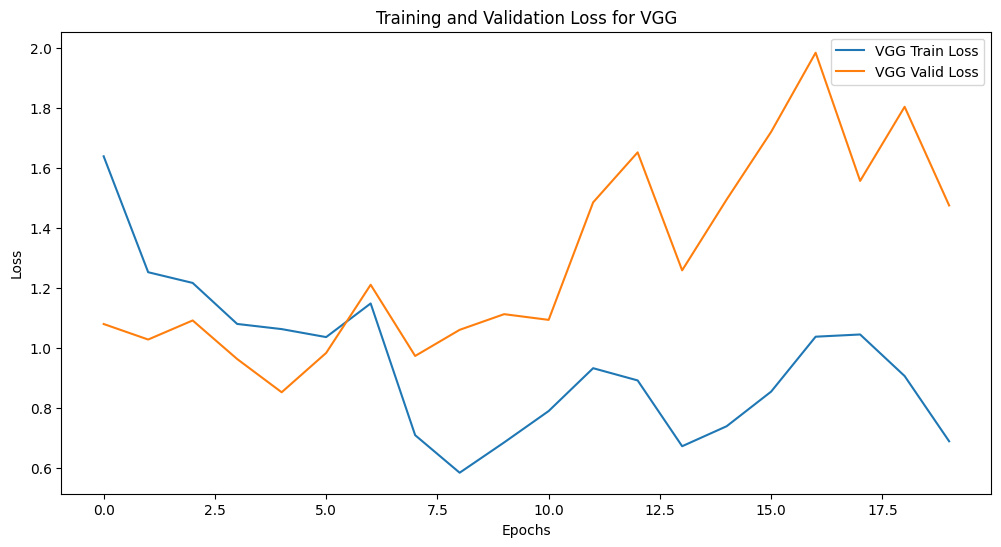

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(vgg_train_loss, label="VGG Train Loss")
plt.plot(vgg_valid_loss, label="VGG Valid Loss")
# Optionally add ResNet or other models' losses for comparison
# plt.plot(resnet_train_loss, label="ResNet Train Loss")
# plt.plot(resnet_valid_loss, label="ResNet Valid Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss for VGG")
plt.show()


In [14]:
# Evaluate VGG model accuracy
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

vgg_test_accuracy = evaluate_model(vgg_model, test_loader)

print(f"VGG Test Accuracy: {vgg_test_accuracy:.2f}%")


VGG Test Accuracy: 79.20%
